### Import Necessary Packages

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

### Defining some global variables

In [2]:
# Defining some global variables
SEED = 42

In [4]:
# Ingest Data
# Training dataset
df=pd.read_csv("E:\\Jupyter\\Kaggle\\House Prices Advanced Regression Techniques\\train.csv")
X = df.iloc[:,:-1]
# Target Variable - House sale price
y = df.loc[:,['SalePrice']]

# Testing dataset
testdata = pd.read_csv("E://Jupyter//Kaggle//House Prices Advanced Regression Techniques//test.csv")

### Data Exploration

Firstly, having a look at columns

In [5]:
X.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Total number of columns and its distribution

In [6]:
len(X.columns)

80

In [7]:
# Prepare a list for different type of columns:
list_null_cols = []
list_numeric_cols = []
list_categorical_cols = []

for col in X.columns:
    col_dtype = X[col].dtype
    if (df[col].isnull().sum()>0):
        list_null_cols.append(col)
    elif col_dtype=="O":
        list_categorical_cols.append(col)
    else:
        list_numeric_cols.append(col)

In [8]:
len(list_null_cols)

19

In [9]:
len(list_numeric_cols)

34

In [10]:
len(list_categorical_cols)

27

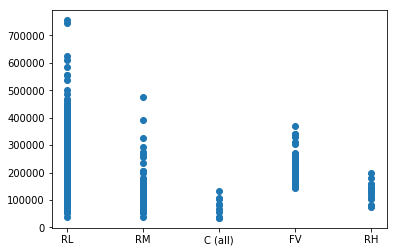

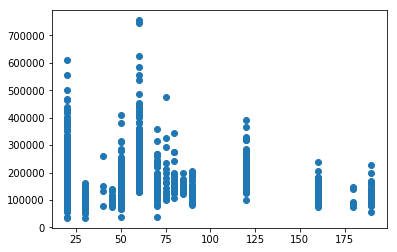

In [11]:
#Checking listing down visualizations
plt.figure(1)
plt.scatter(X.loc[:,'MSZoning'],y.loc[:,'SalePrice'])
plt.figure(2)
plt.scatter(X.loc[:,'MSSubClass'],y.loc[:,'SalePrice'])
plt.show()        

#### Looking at all features

Visualization of all features 

C:\Users\sscaria\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


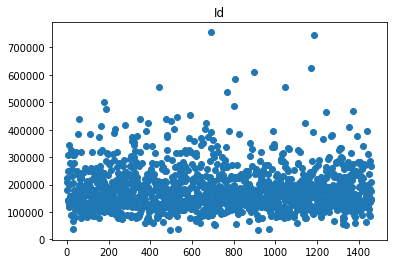

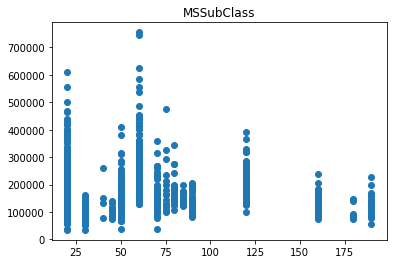

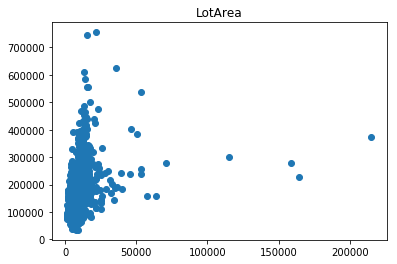

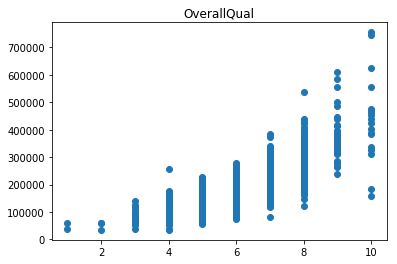

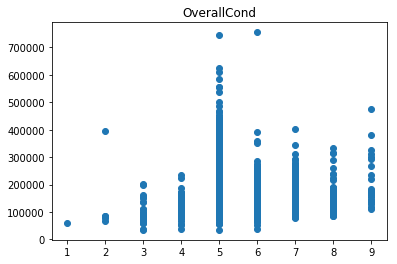

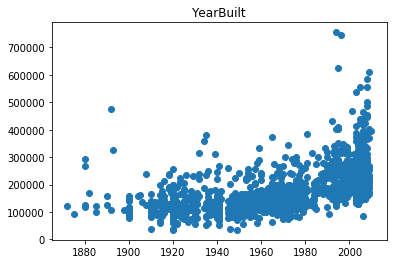

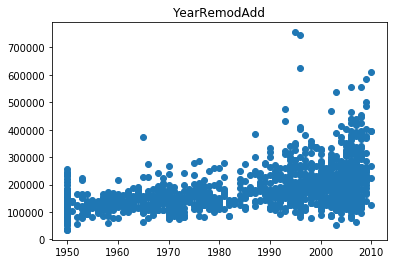

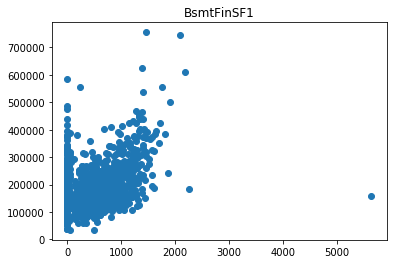

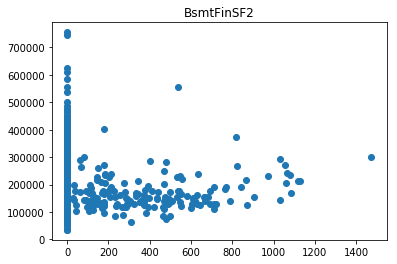

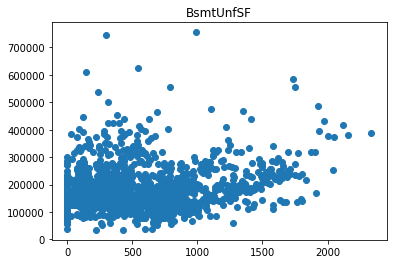

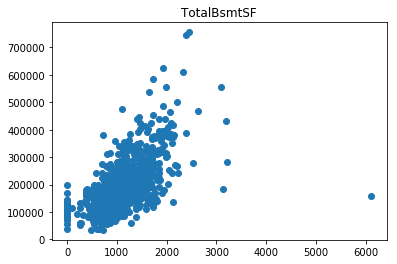

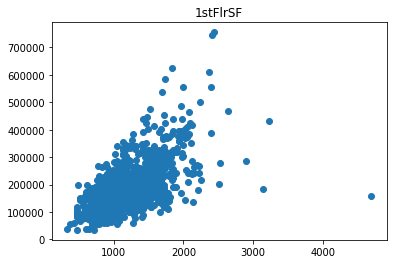

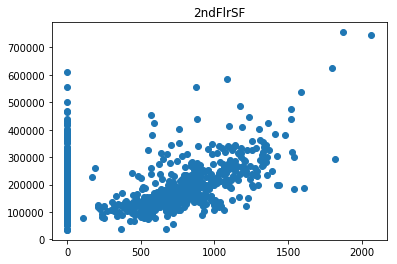

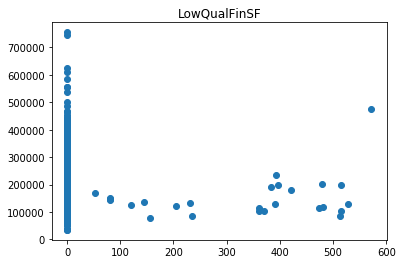

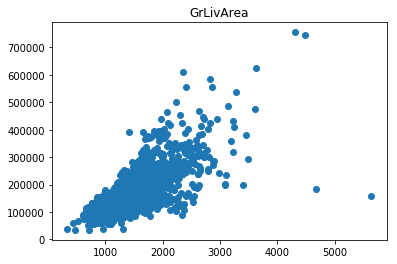

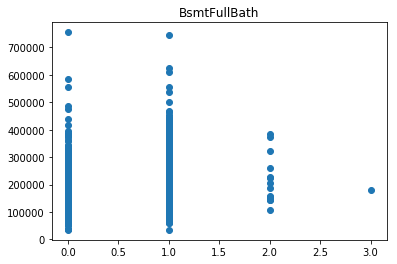

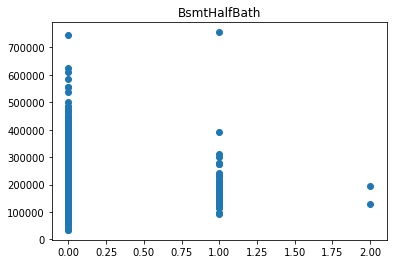

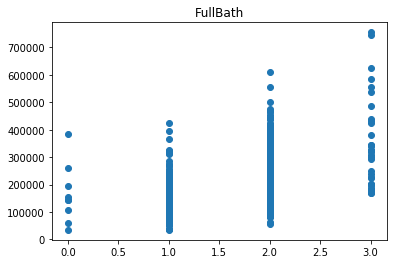

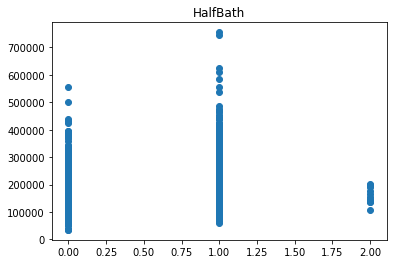

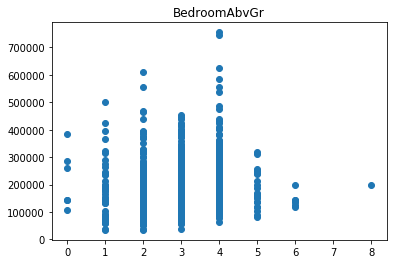

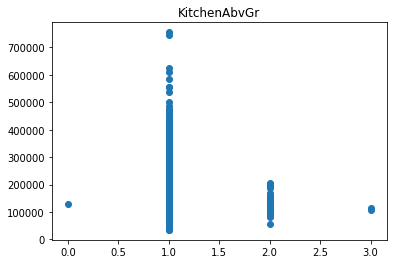

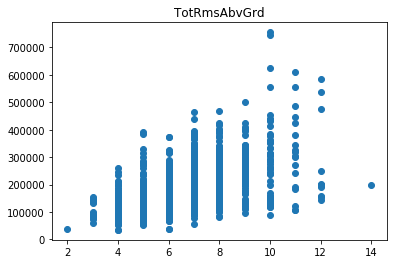

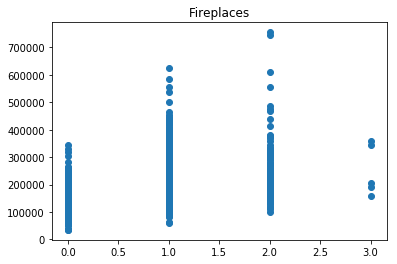

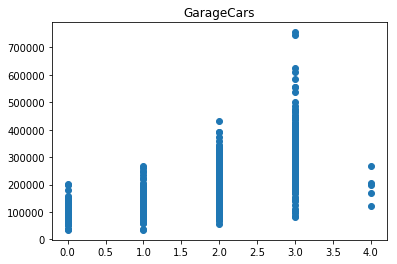

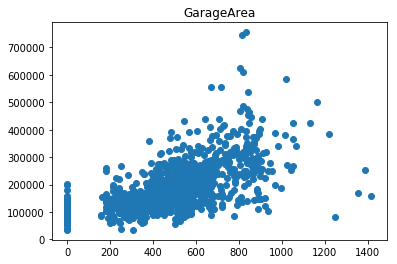

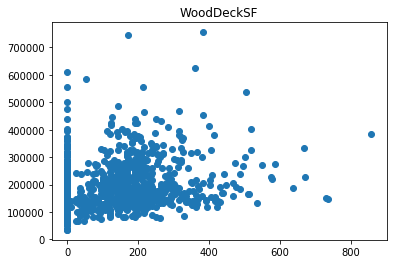

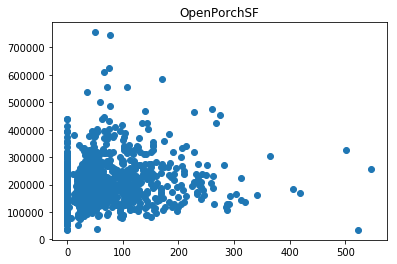

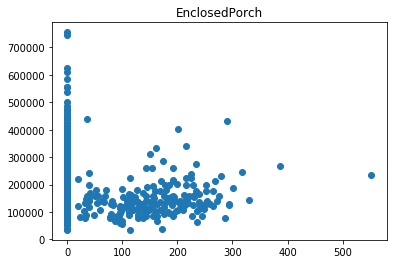

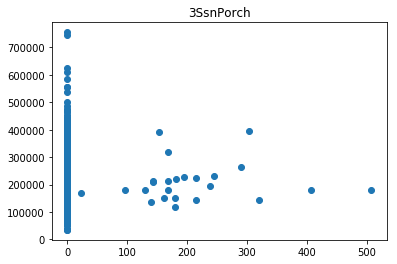

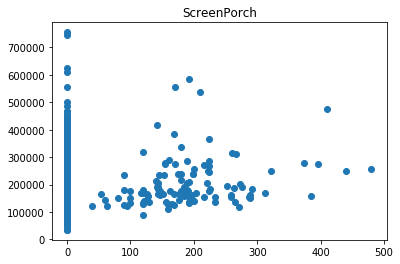

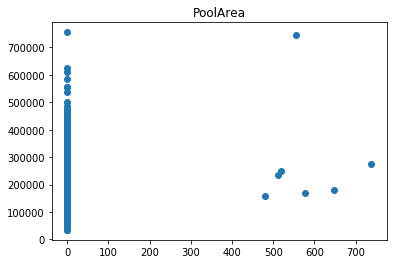

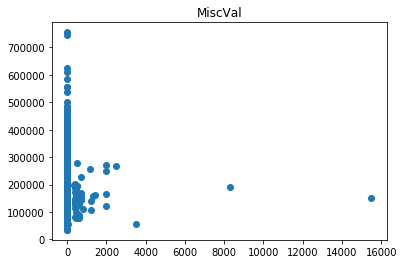

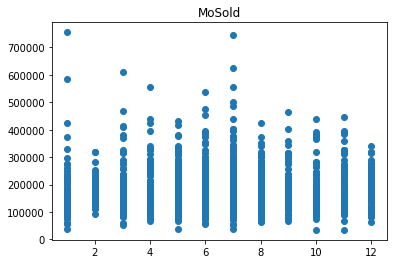

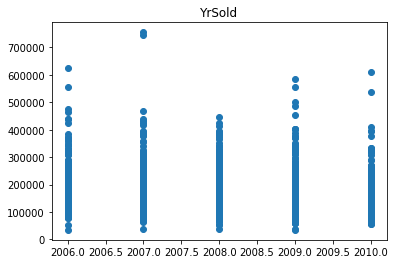

In [12]:
i=0
for col in list_numeric_cols:
    plt.figure(i+1)
    plt.scatter(X.loc[:,col],y.loc[:,'SalePrice'])
    plt.title(col)
    i=i+1

So we have below types of columns:
1. With categorical data (27)
2. With numeric data (35)
3. With null values (19)

### Dealing with categorical data (27)

#### Converting Categorical Data to Numerical data

In [13]:
dfc = X.copy()
dict_categorical_col = {}

In [14]:
for col in list_categorical_cols:
    #Training data
    dict_categorical_col[col]=dfc[col].drop_duplicates().reset_index(drop=True).reset_index()
    dict_categorical_col[col].columns = ['label',col]
    len1=len(dict_categorical_col[col])
    df_temp = pd.DataFrame({'label':[len1],col:['unknown']},columns=['label',col],index=[len1])
    dict_categorical_col[col] = dict_categorical_col[col].append(df_temp)

#### Cleaning Train & Test data

In [15]:
testdata1 = testdata.copy()
X1 = X.copy()
for col in list_categorical_cols:
    #Mapping with dictionary for Train data
    X1 = pd.merge(X1,dict_categorical_col[col],on=col,how='left')
    X1 = X1.drop(columns=col)
    X1.rename(columns={'label':col},inplace=True)
    
    #Checking for null values in Test data
    testdata1[col] = testdata1[col].fillna("unknown")
    #Mapping with dictionary for Test data
    testdata1 = pd.merge(testdata1,dict_categorical_col[col],on=col,how='left')
    testdata1 = testdata1.drop(columns=col)
    testdata1.rename(columns={'label':col},inplace=True)

In [16]:
testdata1['Street'].unique()

array([0, 1], dtype=int64)

### Dealing with numeric data (35)

First deal with missing data related to numeric columns in test data

In [70]:
imputer1 = SimpleImputer()
testdata2 = testdata1.copy()
testdata2[list_numeric_cols] = pd.DataFrame(imputer1.fit_transform(testdata1[list_numeric_cols]))
testdata2.columns = testdata1.columns

Calculation Correlation

In [17]:
from scipy.stats import pearsonr

In [18]:
i_index=0
pearson_corr_df = pd.DataFrame(columns=['column','correlation'],index=[-1])
for col in list_numeric_cols:
    corr,_ = pearsonr(X1.loc[:,col],y.loc[:,'SalePrice'])
    dftest = pd.DataFrame({'column': [col],'correlation':[corr]},columns=['column','correlation'],index=[i_index])
    pearson_corr_df = pearson_corr_df.append(dftest)
    i_index=i_index+1
pearson_corr_df = pearson_corr_df.dropna()
pearson_corr_df.loc[:,'correlation'] = pearson_corr_df.loc[:,'correlation'].abs()

In [19]:
pearson_corr_df=pearson_corr_df.sort_values(by='correlation')

In [20]:
pearson_corr_df.loc[(pearson_corr_df['correlation']>0.5),['correlation']]

,correlation
6,0.507101
5,0.522897
21,0.533723
17,0.560664
11,0.605852
10,0.613581
24,0.623431
23,0.640409
14,0.708624
3,0.790982


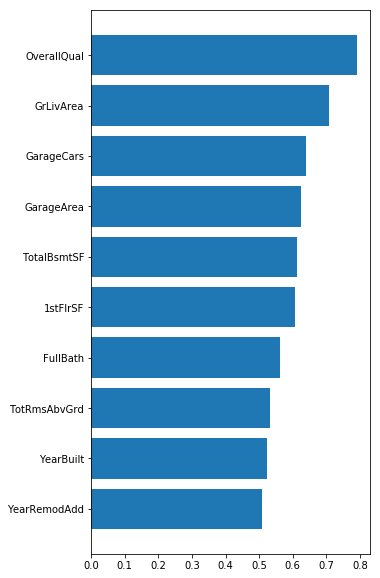

In [21]:
plt.figure(figsize=(5,10))
threshold = 0.5
plot_df = pearson_corr_df.loc[(pearson_corr_df['correlation']>threshold),:]
plt.barh(plot_df.loc[:,'column'],plot_df.loc[:,'correlation'])
plt.show()

In [22]:
type(pearson_corr_df.loc[(pearson_corr_df['correlation']>threshold),['column']])

pandas.core.frame.DataFrame

In [23]:
pearson_corr_df.loc[(pearson_corr_df['correlation']>threshold),['correlation']]

,correlation
6,0.507101
5,0.522897
21,0.533723
17,0.560664
11,0.605852
10,0.613581
24,0.623431
23,0.640409
14,0.708624
3,0.790982


### Dealing with Category 3: With null values (19)

In [24]:
list_null_cols

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [25]:
X.groupby('Fence').size()

Fence
GdPrv     59
GdWo      54
MnPrv    157
MnWw      11
dtype: int64

In [26]:
var_alley = X.loc[:,['Alley']].fillna("No Alley")

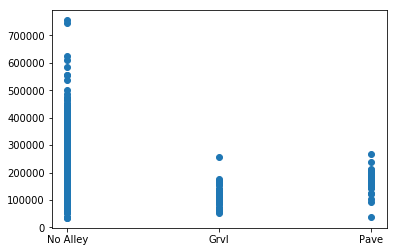

In [27]:
plt.scatter(var_alley.loc[:,'Alley'],y.loc[:,'SalePrice'])

## Model Building

In [30]:
#Step 2: Building initial model on all numerical columns excluding 
#feature_list = list_numeric_cols
feature_list = list_numeric_cols + list_categorical_cols
X1_features = X1[feature_list]

In [31]:
X1_features.shape

(1460, 61)

In [32]:
y.shape

(1460, 1)

In [33]:
#Step 3: Define Train & Test Sets
X_train,X_test,y_train,y_test = train_test_split(X1_features, y, random_state=SEED, test_size=0.2)

In [34]:
y_train.shape

(1168, 1)

In [35]:
#Step 4: Define a Model
dt = DecisionTreeRegressor(random_state=SEED, max_depth=10)

In [36]:
#Step 5: Fitting the model

dt.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

Calculating Training Error

In [37]:
y_train_pred = dt.predict(X_train)
model_train_error = MSE(y_train,y_train_pred)**(1/2)

Calculation Testing Error

In [38]:
y_test_pred = dt.predict(X_test)
model_test_error = MSE(y_test,y_test_pred)**(1/2)

In [39]:
model_train_error

8775.516533672886

In [40]:
model_test_error

44214.280504279865

### Grid Search

In [41]:
params_dt = {'max_depth': range(4,11),
            'min_samples_leaf':[0.04,0.06,0.08],
            'max_features':[0.2,0.3,0.4,0.5,0.6,0.7,0.8]}

In [42]:
grid_dt = GridSearchCV(estimator = dt, 
                       param_grid = params_dt, 
                       scoring ='neg_mean_squared_error',
                       cv=10,
                       n_jobs=-1
                      )

In [43]:
grid_dt.fit(X1_features,y)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': range(4, 11), 'min_samples_leaf': [0.04, 0.06, 0.08], 'max_features': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [44]:
grid_dt.best_params_

{'max_depth': 7, 'max_features': 0.6, 'min_samples_leaf': 0.04}

In [45]:
selectedmodel = grid_dt.best_estimator_

In [46]:
#Calculating Training error

In [47]:
y_train_pred_selectedmodel= selectedmodel.predict(X_train)
y_train_pred_selectedmodel_trainerror = MSE(y_train,y_train_pred_selectedmodel)**(1/2)

In [48]:
#Calculating Testing error

In [49]:
y_test_pred_selectedmodel= selectedmodel.predict(X_test)
y_test_pred_selectedmodel_testerror = MSE(y_test,y_test_pred_selectedmodel)**(1/2)

In [50]:
y_train_pred_selectedmodel_trainerror

40188.9719323371

In [51]:
y_test_pred_selectedmodel_testerror

46142.546146025874

### Now lets repeat the same for Gradient Boosting

In [52]:
gbt = GradientBoostingRegressor(random_state=SEED)

In [53]:
# params_gbt = { 'n_estimators':[100,150,200,250,300,350,400,450,500],
#               'max_depth': [5,6,7,10,50,80,100]
#              }
# Grid Search gave best depth as 6 & number of estimators as 250

In [54]:
params_gbt = { 'n_estimators':[250],
              'max_depth': [6]
             }

In [55]:
gbt_gcv = GridSearchCV(estimator = gbt,
                       param_grid = params_gbt,
                       scoring='neg_mean_squared_error',
                       cv=10,
                       n_jobs=-1
                      )

In [56]:
gbt_gcv.fit(X1_features,y)

C:\Users\sscaria\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...te=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [250], 'max_depth': [6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [57]:
gbt_gcv.best_params_

{'max_depth': 6, 'n_estimators': 250}

In [58]:
selectedmodel_gbt = gbt_gcv.best_estimator_

In [59]:
#Calculating train error
y_train_pred_selectedmodel_gbt= selectedmodel_gbt.predict(X_train)
y_train_pred_selectedmodel_trainerror_gbt = MSE(y_train,y_train_pred_selectedmodel_gbt)**(1/2)

In [60]:
#Calculating test error
y_test_pred_selectedmodel_gbt= selectedmodel_gbt.predict(X_test)
y_test_pred_selectedmodel_testerror_gbt = MSE(y_test,y_test_pred_selectedmodel_gbt)**(1/2)

In [61]:
y_train_pred_selectedmodel_trainerror_gbt

1731.573481810145

In [62]:
y_test_pred_selectedmodel_testerror_gbt

1906.3536353272984

### Now lets look at using plotting trainerror & testerror for different max_depth

In [63]:
import numpy as np
list_max_depth = range(1,8)
train_errors = list()
test_errors = list()
for treedepth in list_max_depth:
    dt_model = DecisionTreeRegressor(random_state=SEED, max_depth = treedepth)
    dt_model.fit(X_train,y_train)
    train_errors.append(dt_model.score(X_train,y_train))
    test_errors.append(dt_model.score(X_test,y_test))

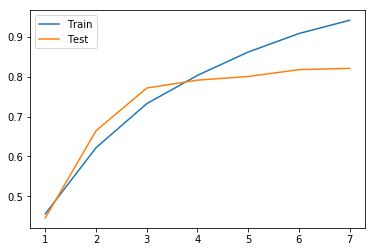

In [64]:
plt.plot(np.array(list_max_depth),np.array(train_errors), label='Train')
plt.plot(np.array(list_max_depth),np.array(test_errors), label='Test')
plt.legend(loc='upper left')
plt.show()

### For Predictions

In [71]:
y_predictions = selectedmodel_gbt.predict(testdata2[feature_list])

In [72]:
output = pd.DataFrame({'Id': testdata.Id,
                       'SalePrice': y_predictions})
output.to_csv('submission1.csv', index=False)

In [73]:
selectedmodel_gbt.feature_importances_

array([2.84729518e-03, 1.11286075e-03, 1.66331785e-02, 6.14350710e-01,
       6.27629960e-03, 1.58729397e-02, 1.06279436e-02, 2.80172671e-02,
       8.92059995e-04, 3.64122239e-03, 3.80947194e-02, 2.56588179e-02,
       3.78609338e-02, 1.34074174e-05, 1.03739452e-01, 1.14357028e-03,
       2.30035988e-04, 2.17234997e-03, 7.87608865e-04, 1.02417832e-03,
       1.71079366e-03, 4.45196464e-03, 4.36956814e-03, 2.07748838e-02,
       1.21178925e-02, 5.52818351e-03, 3.18076517e-03, 6.48475699e-04,
       6.06161235e-04, 6.54374028e-04, 7.42750381e-05, 2.67570496e-05,
       3.10700685e-03, 6.39186061e-04, 2.00643595e-03, 1.94042233e-08,
       1.32886673e-03, 5.20493903e-04, 4.65572764e-07, 1.89220877e-03,
       4.99518264e-04, 3.45077811e-03, 7.07328477e-04, 1.73060615e-05,
       4.53781576e-04, 7.60195398e-04, 3.18730613e-04, 7.64590768e-04,
       2.01669901e-03, 1.27702679e-03, 2.47178603e-03, 8.14401900e-04,
       2.35596324e-04, 3.05587051e-05, 2.63967477e-04, 3.09299920e-03,
      

In [76]:
importances_dt = pd.Series(selectedmodel_gbt.feature_importances_,index=testdata2[feature_list].columns)

In [77]:
sorted_importances_dt = importances_dt.sort_values()

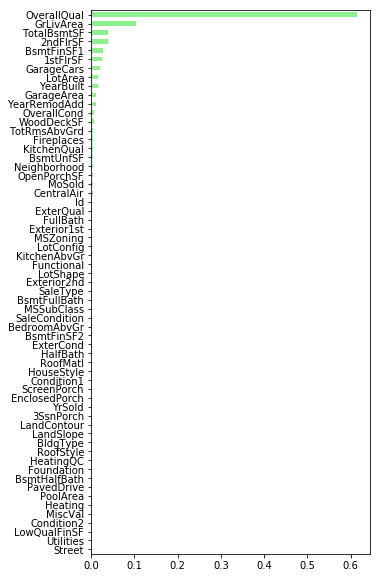

In [78]:
plt.figure(figsize=(5,10))
sorted_importances_dt.plot(kind='barh',color='lightgreen')

plt.show()